## Solving a equation with PINNs using the neurodiffeq module



Documentation: https://neurodiffeq.readthedocs.io/en/latest/index.html

Let's consider the equation

$$x^{\prime\prime}-\alpha x=0$$

where $\alpha$ is a parameter of the model. If we use a numerical integrator, we need to fix the value of $\alpha$ each time we integrate the equation. One important goal of the Neurodiffeq library is the bundle method, which allows solving the differential equation as a function of parameters. The analytical solution in this case is:

$$x(t,\alpha) = \frac{1}{2}e^{\sqrt{\alpha}t} + \frac{1}{2}e^{-\sqrt{\alpha}t}$$

And from this it follows that:

$$y(t,\alpha) = \sqrt{\alpha}\left(\frac{1}{2}e^{\sqrt{\alpha}t} - \frac{1}{2}e^{-\sqrt{\alpha}t}\right)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from neurodiffeq.solvers import BundleSolver1D
from neurodiffeq.conditions import BundleIVP
from neurodiffeq import diff
from neurodiffeq.generators import Generator1D
from neurodiffeq.networks import FCNN

In [2]:
from neurodiffeq.utils import set_tensor_type #This is not necessary 
set_tensor_type(device='cpu', float_bits=64)

# Ejercicio

Consider the equation

$$x^{\prime\prime}(t)+\alpha x^{\prime}(t)-\beta x(t)=0$$

with initial conditions: $x(0)=1$, $x^\prime(0)=0$, and $t \in [0,1]$.

**a)** Solve the equation using the `neurodiffeq` module for the values $\alpha = \beta = 1$. Note: you CAN'T fix $\beta=0$ and use the bundle method only for $\alpha$.

**b)** Compute the percentage difference between the PINN-based solution and the analytical one in the range $[0,1]$. Now do the same for the range $[-1,2]$.

**Hint:** The analytical solution for these parameter values is:

$$x(t) = \frac{1}{2\sqrt{5}}\left((1+\sqrt{5})e^{(-1+\sqrt{5})t/2}+(-1+\sqrt{5})e^{-(1+\sqrt{5})t/2}\right)$$

**c)** Achieve an accuracy such that the percentage error is less than 1% for all values of t (if your solution is not so good, go back to training!).

**d)** Compute and plot the residuals and try to interpretate them.

Send your solution to gomezlucajavier@gmail.com.

**Note:** You can solve this exercise with or without using the *bundle method*. If you choose to use the bundle method, be careful with the number of inputs to the networks, and also with the definition of `eq_param_index` in the solver. While the bundle method might make it easier to follow the structure of the code, it may also lead to longer training times.


Lo primero que hago es hacer un cambio de variables para bajar el orden de mi ecuación, entonces ahora tendré dos ecuaciones de primer orden:

$$x^{\prime}-y=0$$
$$y^{\prime}+\alpha y-\beta x=0$$
Luego, $x(0)=1$, $y(0) = x^\prime(0)=0$, y $t \in [0,1]$.


In [3]:
#Rango de la variable independiente
t_0 = 0
t_f = 1

t_00 = -1
t_ff = 2

#rango de los parametros de bundle
alpha_0 = 0.9
alpha_f = 1.1
beta_0 = 0.9
beta_f = 1.1


def ODE(x, x_p, t, alpha=1, beta=1):
    res1 = diff(x, t) - x_p
    res2 = diff(x_p, t) + alpha * x_p - beta*x
    return [res1 , res2]

#condiciones iniciales
x_0 = 1
y_0 = 0
conds = [BundleIVP(t_0, x_0), BundleIVP(t_0, y_0)]

condss = [BundleIVP(t_00, x_0), BundleIVP(t_00, y_0)]

#Defino la funcion perdida a partir de los residuos:
def loss(res, x, t):
    loss = res ** 2
    return loss.mean()

#Definimos la arquitectura de las redes:
#Tenemos 3 inputs: (t, alpha, beta) y definimos dos redes two networks, una para cada ecuación.
redes = [FCNN(n_input_units=3,  hidden_units=(40,40,)) for _ in range(2)]

#Defino el optimizador del entrenamiento de la red (ADAM) y le definimos el learning rate.Define the optimizator for the trainig.
adam = torch.optim.Adam(set([p for red in redes for p in red.parameters()]), lr=1e-3)

#Defino los datos de entrenamiento y validación


batch_size = 5
tg_t = Generator1D(batch_size, t_min=t_0, t_max=t_f)
vg_t = Generator1D(batch_size, t_min=t_0, t_max=t_f)

tg_alpha = Generator1D(batch_size, t_min=alpha_0, t_max=alpha_f)
vg_alpha = Generator1D(batch_size, t_min=alpha_0, t_max=alpha_f)

tg_beta = Generator1D(batch_size, t_min=beta_0, t_max=beta_f)
vg_beta = Generator1D(batch_size, t_min=beta_0, t_max=beta_f)

train_gen = tg_t ^ tg_alpha ^ tg_beta
valid_gen = vg_t ^ vg_alpha ^ vg_beta

In [4]:
solver = BundleSolver1D(
    ode_system=ODE,
    conditions=conds,
    t_min=t_0,
    t_max=t_f,
    theta_min=(alpha_0, beta_0),
    theta_max=(alpha_f, beta_f),
    eq_param_index=(0, 1),  # índices relativos a los parámetros bundle
    nets=redes,
    train_generator=train_gen,
    valid_generator=valid_gen,
    optimizer=adam,
    loss_fn=loss,
)


In [9]:
iterations = 5000
solver.fit(iterations)

Training Progress:   0%|                                                                      | 0/5000 [00:00<…

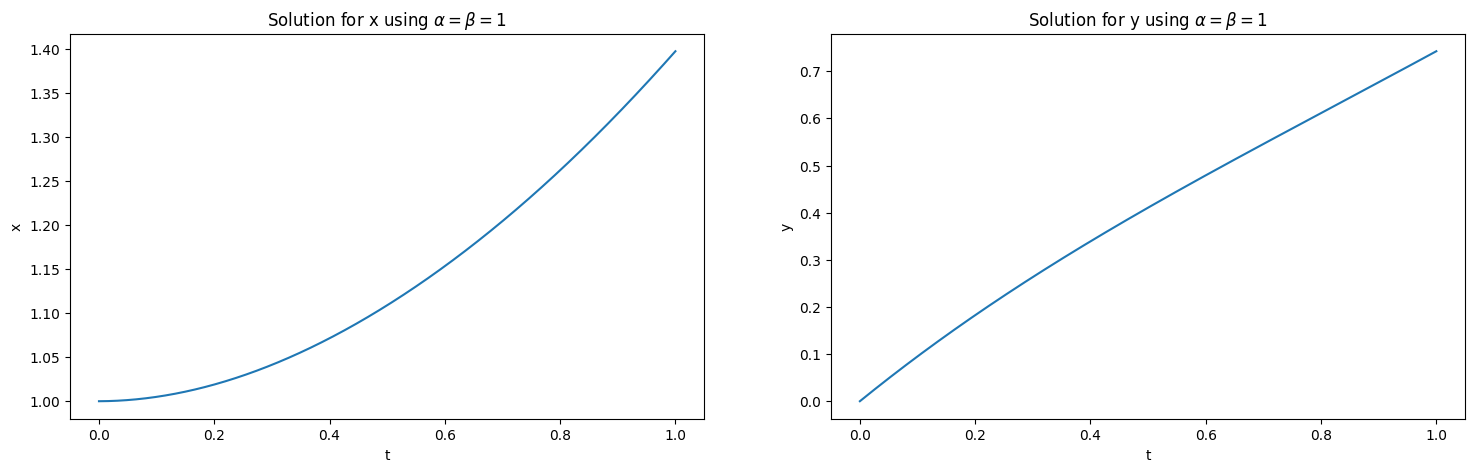

In [10]:
v_sol = solver.get_solution()
ts = np.linspace(t_0,t_f,1000)
tss = np.linspace(t_00,t_ff,1000)
alpha=1
alphas = alpha * np.ones_like(ts)
beta = 1
betas = beta * np.ones_like(ts)
x, y = v_sol(ts, alphas, betas, to_numpy=True)


fig, ax = plt.subplots(1, 2, figsize=(18,5))
ax[0].plot(ts, x)
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[0].set_title(r'Solution for x using $\alpha = \beta = 1$')
ax[1].plot(ts, y)
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].set_title(r'Solution for y using $\alpha = \beta = 1$')
plt.show()

C:\Users\smili\AppData\Local\Temp\ipykernel_44700\3942432223.py:22: RuntimeWarning: invalid value encountered in divide
  perc_err_y = 100 * np.abs(y - y_exact)/np.abs(y_exact)


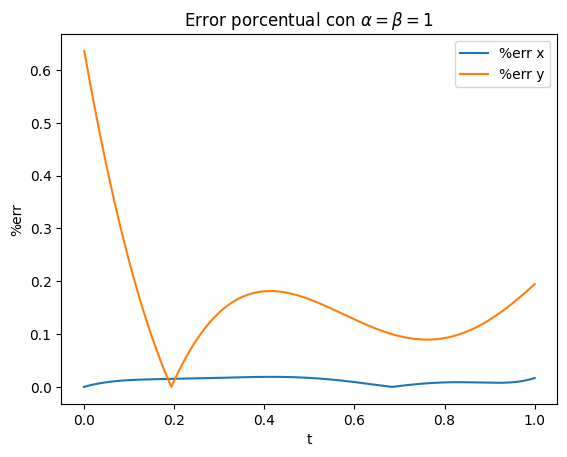

In [11]:
#solucion exacta para x(t) con alpha y beta igual a 1
def sol_exacta(t):
    n = (1 + np.sqrt(5)) * np.exp((-1 + np.sqrt(5)) * t / 2)
    d = (-1 + np.sqrt(5)) * np.exp((-1 - np.sqrt(5)) * t / 2)
    return (1 / (2 * np.sqrt(5))) * (n + d)

x_exact = sol_exacta(ts)

#solucion exacta de x'(t) con alpha y beta igual a 1
def sol_exacta_derivada(t):
    k1 = (-1 + np.sqrt(5)) / 2
    k2 = (-1 - np.sqrt(5)) / 2

    n = (1 + np.sqrt(5)) * k1 * np.exp(k1 * t)
    d = (-1 + np.sqrt(5)) * k2 * np.exp(k2 * t)

    return (1 / (2 * np.sqrt(5))) * (n + d)

y_exact = sol_exacta_derivada(ts)

perc_err_x = 100 * np.abs(x - x_exact)/np.abs(x_exact)
perc_err_y = 100 * np.abs(y - y_exact)/np.abs(y_exact)

plt.figure()
plt.plot(ts, perc_err_x, label = '%err x')
plt.plot(ts, perc_err_y, label = '%err y')
plt.xlabel('t')
plt.ylabel('%err')
plt.title(r'Error porcentual con $\alpha = \beta= 1$')
plt.legend()
plt.show()

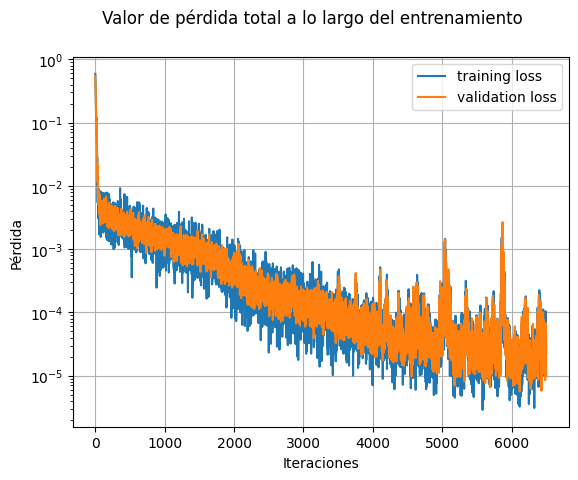

In [12]:
plt.figure()
perdida_train = solver.metrics_history['train_loss']
perdida_valid = solver.metrics_history['valid_loss']
plt.plot(perdida_train, label='training loss')
plt.plot(perdida_valid, label='validation loss')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.yscale('log')
plt.grid()
plt.legend()
plt.suptitle('Valor de pérdida total a lo largo del entrenamiento')
#plt.savefig('loss_example_bundle.png')
plt.show()

torch.save(solver._get_internal_variables()['best_nets'], 'bundle_model.ph') #guardamos la red asi

Podemos ver que tanto con los datos de entrenamiento y los datos de entrenamiento nunca dejan de bajar. Podriamos hacer mas iteraciones y aún asi seguiria bajando. Es decir aprende mas con cada iteración.

Me está tardando mucho, podria poner mas neuronas pero va a durar un monton mas o mas iteraciones lo mismo.

Me piden ver en el intervalor extendido  [-1, 2], podria usar la red entrenada en el intervalor [0,1], o si o si tengo que entrenar una red en ese intervalo extendido?